# Denoise Diffusion Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-colorblind")

import math

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    optimizers,
    utils,
    callbacks,
    metrics,
    losses,
    activations,
)

import matplotlib.pyplot as plt

In [2]:
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()


# parameters

In [3]:
IMAGE_SIZE = 64
BATCH_SIZE = 64
DATASET_REPETITIONS = 5
LOAD_MODEL = True

NOISE_EMBEDDING_SIZE = 32
PLOT_DIFFUSION_STEPS = 20

# optimization
EMA = 0.999
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 50

In [4]:
# loading data
train_data = utils.image_dataset_from_directory(
    "data",
    labels=None,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=None,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 8189 files belonging to 1 classes.


In [5]:
# Preprocess the data
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img


train = train_data.map(lambda x: preprocess(x))
train = train.repeat(DATASET_REPETITIONS)
train = train.batch(BATCH_SIZE, drop_remainder=True)

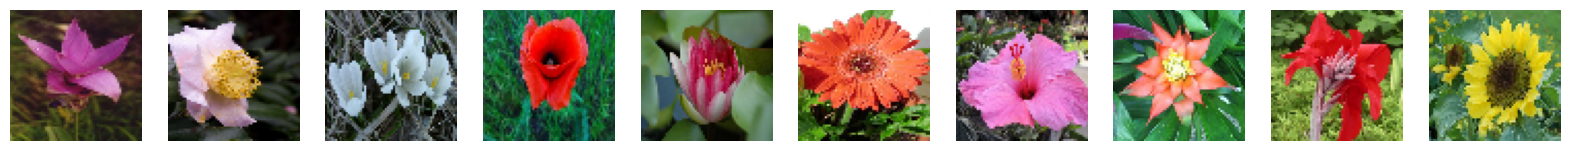

In [6]:
# Show some items of clothing from the training set
train_sample = sample_batch(train)
display(train_sample)

# Diffusion schedulers

In first diffusion models, linear diffusion schedule is used, but later found out cosine scheduler diffuses the model, even better, to avoid low rate at starting, offset is introduced in cosine scheduler

In [7]:
def linear_diffusion_schedule(diffusion_times):
    min_rate = 0.0001
    max_rate = 0.02
    betas = min_rate + diffusion_times * (max_rate - min_rate)
    alphas = 1 - betas
    alpha_bars = tf.math.cumprod(alphas)
    signal_rates = tf.sqrt(alpha_bars)
    noise_rates = tf.sqrt(1 - alpha_bars)
    return noise_rates, signal_rates

def cosine_diffusion_schedule(diffusion_times):
    signal_rates = tf.cos(diffusion_times * math.pi / 2)
    noise_rates = tf.sin(diffusion_times * math.pi / 2)
    return noise_rates, signal_rates

def offset_cosine_diffusion_schedule(diffusion_times):
    min_signal_rate = 0.02
    max_signal_rate = 0.95
    start_angle = tf.acos(max_signal_rate)
    end_angle = tf.acos(min_signal_rate)

    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

    signal_rates = tf.cos(diffusion_angles)
    noise_rates = tf.sin(diffusion_angles)

    return noise_rates, signal_rates

In [8]:
T = 1000
diffusion_times = tf.convert_to_tensor([x / T for x in range(T)])

linear_noise_rates, linear_signal_rates = linear_diffusion_schedule(diffusion_times)
cosine_noise_rates, cosine_signal_rates = cosine_diffusion_schedule(diffusion_times)
offset_cosine_noise_rates, offset_cosine_signal_rates= offset_cosine_diffusion_schedule(diffusion_times)

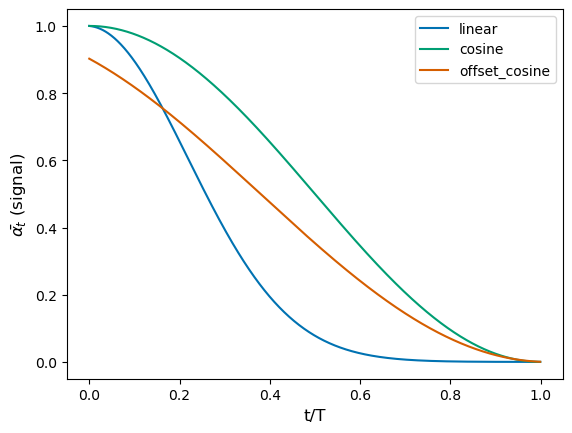

In [9]:
plt.plot(diffusion_times, linear_signal_rates**2, linewidth=1.5, label="linear")
plt.plot(diffusion_times, cosine_signal_rates**2, linewidth=1.5, label="cosine")

plt.plot(
    diffusion_times,
    offset_cosine_signal_rates**2,
    linewidth=1.5,
    label="offset_cosine",
)

plt.xlabel("t/T", fontsize=12)
plt.ylabel(r"$\bar{\alpha_t}$ (signal)", fontsize=12)
plt.legend()
plt.show()

In [10]:
# Sinusoidal embeddings for variance

In [11]:
def sinusoidal_embedding(x):
    frequencies = tf.exp(tf.linspace(tf.math.log(1.0),tf.math.log(1000.0), NOISE_EMBEDDING_SIZE//2))
    angular_speeds = 2.0*math.pi*frequencies
    embeddings = tf.concat([tf.sin(angular_speeds*x),tf.cos(angular_speeds*x)],axis=3)
    return embeddings

100 (32, 100)


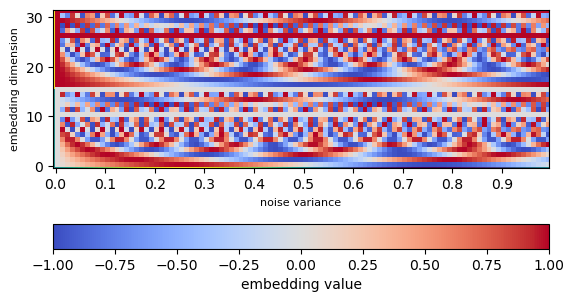

In [12]:
embedding_list = []
for y in np.arange(0, 1, 0.01):
    embedding_list.append(sinusoidal_embedding(np.array([[[[y]]]]))[0][0][0])
embedding_array = np.array(np.transpose(embedding_list))
print(len(embedding_list), embedding_array.shape)
fig, ax = plt.subplots()
ax.set_xticks(
    np.arange(0, 100, 10), labels=np.round(np.arange(0.0, 1.0, 0.1), 1)
)
ax.set_ylabel("embedding dimension", fontsize=8)
ax.set_xlabel("noise variance", fontsize=8)
plt.pcolor(embedding_array, cmap="coolwarm")
plt.colorbar(orientation="horizontal", label="embedding value")
ax.imshow(embedding_array, interpolation="nearest", origin="lower")
plt.show()

In [13]:
#Unet model

In [14]:
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply

In [15]:
# Build the U-Net

noisy_images = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = layers.Conv2D(32, kernel_size=1)(noisy_images)

noise_variances = layers.Input(shape=(1, 1, 1))
noise_embedding = layers.Lambda(sinusoidal_embedding)(noise_variances)
noise_embedding = layers.UpSampling2D(size=IMAGE_SIZE, interpolation="nearest")(
    noise_embedding
)

x = layers.Concatenate()([x, noise_embedding])

skips = []

x = DownBlock(32, block_depth=2)([x, skips])
x = DownBlock(64, block_depth=2)([x, skips])
x = DownBlock(96, block_depth=2)([x, skips])

x = ResidualBlock(128)(x)
x = ResidualBlock(128)(x)

x = UpBlock(96, block_depth=2)([x, skips])
x = UpBlock(64, block_depth=2)([x, skips])
x = UpBlock(32, block_depth=2)([x, skips])

x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

unet = models.Model([noisy_images, noise_variances], x, name="unet")

In [16]:
unet.summary()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1, 1, 1)]    0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 lambda (Lambda)                (None, 1, 1, 32)     0           ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   128         ['input_1[0][0]']                
                                                                                               

 conv2d_15 (Conv2D)             (None, 16, 16, 96)   83040       ['conv2d_14[0][0]']              
                                                                                                  
 add_5 (Add)                    (None, 16, 16, 96)   0           ['conv2d_15[0][0]',              
                                                                  'add_4[0][0]']                  
                                                                                                  
 average_pooling2d_2 (AveragePo  (None, 8, 8, 96)    0           ['add_5[0][0]']                  
 oling2D)                                                                                         
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 8, 8, 96)    192         ['average_pooling2d_2[0][0]']    
 rmalization)                                                                                     
          

 ormalization)                                                                                    
                                                                                                  
 conv2d_31 (Conv2D)             (None, 32, 32, 64)   73792       ['batch_normalization_11[0][0]'] 
                                                                                                  
 conv2d_32 (Conv2D)             (None, 32, 32, 64)   36928       ['conv2d_31[0][0]']              
                                                                                                  
 conv2d_30 (Conv2D)             (None, 32, 32, 64)   8256        ['concatenate_4[0][0]']          
                                                                                                  
 add_11 (Add)                   (None, 32, 32, 64)   0           ['conv2d_32[0][0]',              
                                                                  'conv2d_30[0][0]']              
          

In [17]:
# define the class of model

class DiffusionModel(models.Model):
    def __init__(self):
        super().__init__()
        
        self.normalizer = layers.Normalization()
        self.network = unet
        self.ema_network = models.clone_model(self.network)
        self.diffusion_schedule = offset_cosine_diffusion_schedule
        
    def compile(self, **kwargs):
        super().compile(**kwargs)
        self.noise_loss_tracker = metrics.Mean(name="n_loss")

    @property
    def metrics(self):
        return [self.noise_loss_tracker]
    
    def denormalize(self, images):
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)
    
    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        if training:
            network = self.network
        else:
            network = self.ema_network
        
        pred_noises = network([noisy_images,noise_rates**2], training = training)
        pred_images = (noisy_images - pred_noises*noise_rates)/signal_rates
        return pred_noises, pred_images
    
    def reverse_diffusion(self, initial_noise, diffusion_steps):
        num_images = initial_noise.shape[0]
        step_size = 1.0/diffusion_steps
        current_images = initial_noise
        
        for step in range(diffusion_steps):
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(current_images, noise_rates, signal_rates, training = False)
            
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(next_diffusion_times)
            
            current_images = (next_signal_rates*pred_images+next_noise_rates*pred_noises)
        return pred_images
    
    def generate(self, num_images, diffusion_steps, initial_noise = None):
        if initial_noise is None : 
            initial_noise = tf.random.normal(shape = (num_images,IMAGE_SIZE,IMAGE_SIZE,3))
        
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_images = self.denormalize(generated_images)
        
        return generated_images
    
    def train_step(self, images):
        images = self.normalizer(images, training = True)
        noises = tf.random.normal(shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3))
        
        diffusion_times = tf.random.uniform(shape = (BATCH_SIZE,1,1,1),minval=0.0, maxval=1.0)
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        
        noisy_images = signal_rates*images + noise_rates*noises
        
        with tf.GradientTape() as tape:
            pred_noises, pred_images = self.denoise(noisy_images, noise_rates, signal_rates, training= True)
            noise_loss = self.loss(noises, pred_noises)
        
        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients,self.network.trainable_weights))
        
        self.noise_loss_tracker.update_state(noise_loss)
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(EMA * ema_weight + (1 - EMA) * weight)

        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self,images):
        images = self.normalizer(images, training=False)
        noises = tf.random.normal(shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3))
        diffusion_times = tf.random.uniform(
            shape=(BATCH_SIZE, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        noisy_images = signal_rates * images + noise_rates * noises
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )
        noise_loss = self.loss(noises, pred_noises)
        self.noise_loss_tracker.update_state(noise_loss)

        return {m.name: m.result() for m in self.metrics}

In [18]:
ddm = DiffusionModel()
ddm.normalizer.adapt(train)

In [19]:
if LOAD_MODEL:
    ddm.built = True
    ddm.load_weights("checkpoint.ckpt")

In [20]:
# training the model

In [21]:
ddm.compile(
    optimizer=optimizers.experimental.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    ),
    loss=losses.mean_absolute_error,
)

In [22]:
# run training and plot generated images periodically
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generate(
            num_images=self.num_img,
            diffusion_steps=PLOT_DIFFUSION_STEPS,
        ).numpy()
        display(
            generated_images,
            save_to="generated_img_%03d.png" % (epoch),
        )

image_generator_callback = ImageGenerator(num_img=10)

Epoch 1/50
639/639 [==============================] - ETA: 0s - n_loss: 0.1773
Saved to generated_img_000.png


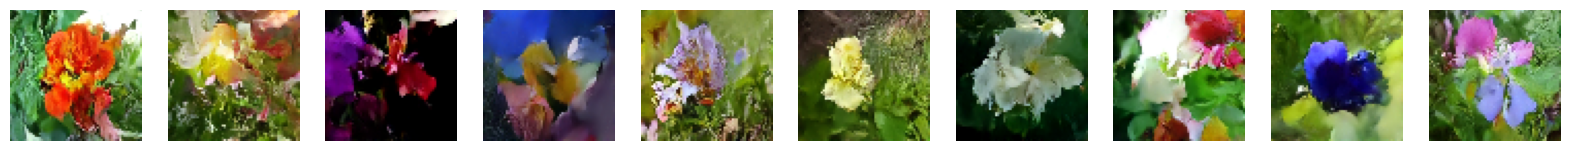

639/639 [==============================] - 4025s 6s/step - n_loss: 0.1773
Epoch 2/50
639/639 [==============================] - ETA: 0s - n_loss: 0.1770
Saved to generated_img_001.png


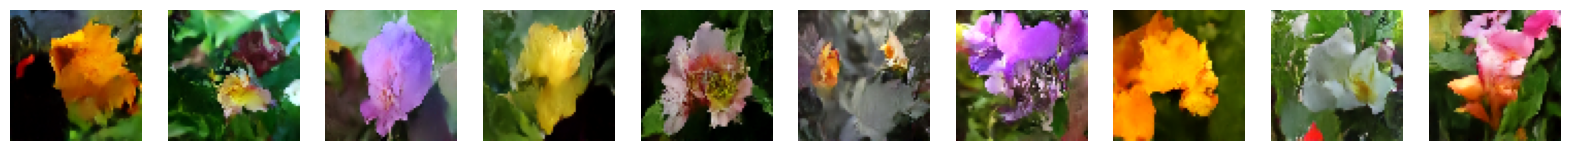

639/639 [==============================] - 3564s 6s/step - n_loss: 0.1770
Epoch 3/50
  1/639 [..............................] - ETA: 1:24:13 - n_loss: 0.2029

KeyboardInterrupt: 

In [28]:

history = ddm.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        image_generator_callback,
    ],
)

In [29]:
unet.save('unet_11_epoches.h5')

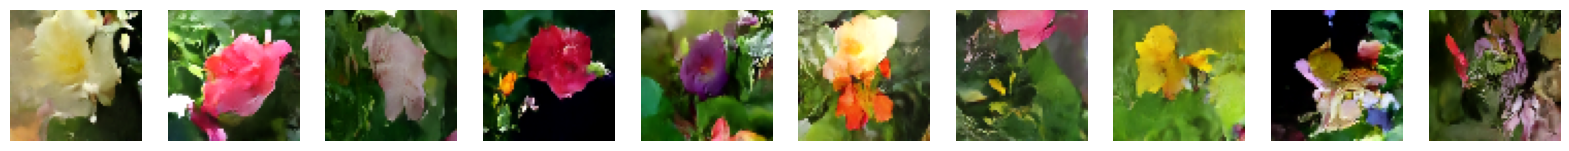

In [30]:
# Generate some novel images of flowers
generated_images = ddm.generate(num_images=10, diffusion_steps=20).numpy()
display(generated_images)

diffusion step: 1


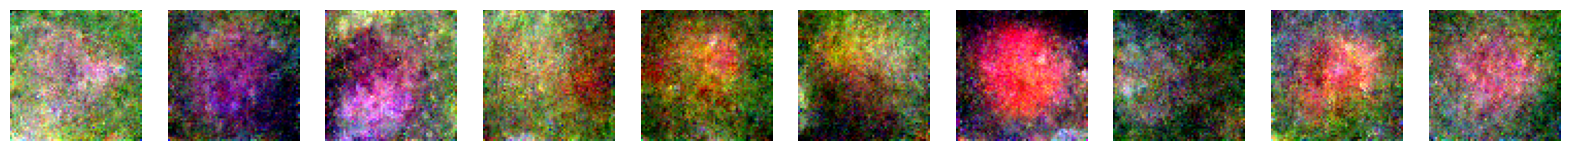

diffusion step: 2


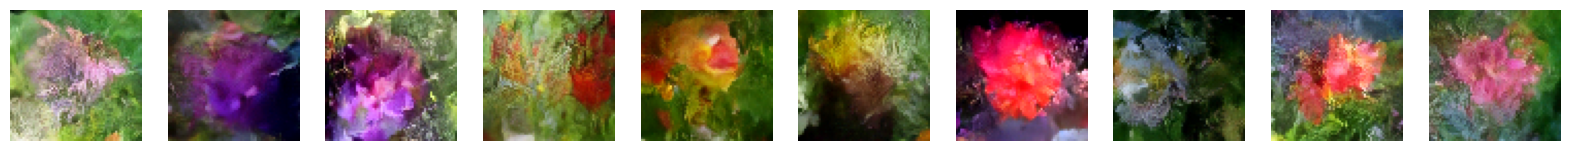

diffusion step: 3


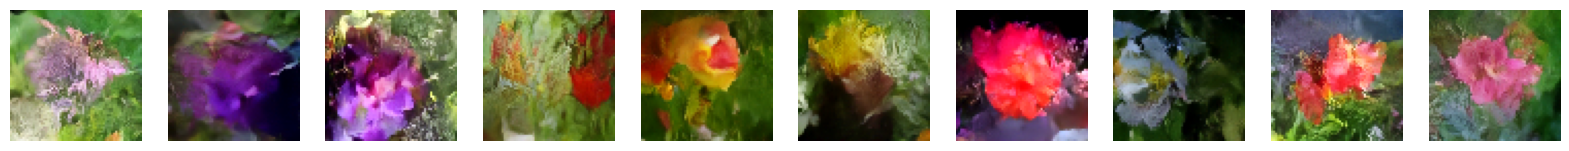

diffusion step: 4


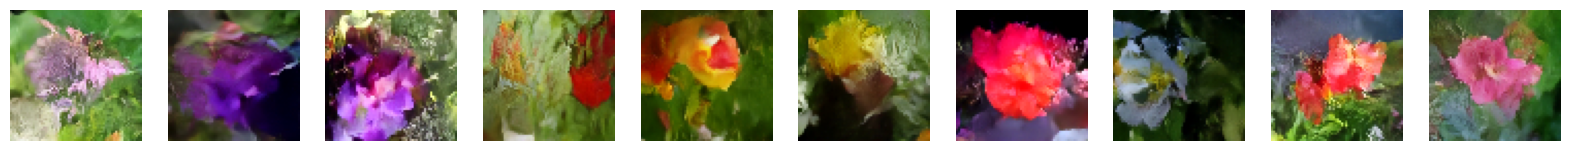

diffusion step: 5


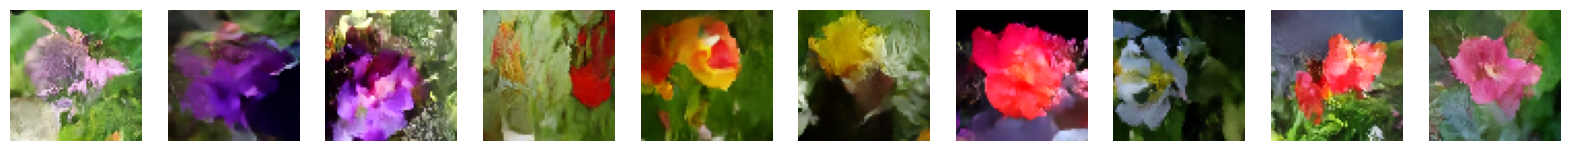

diffusion step: 20


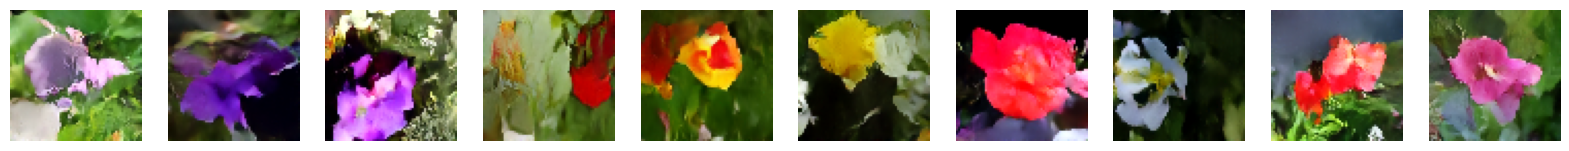

diffusion step: 100


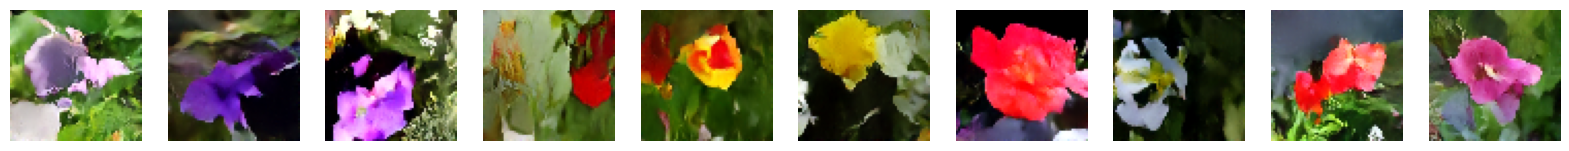

In [42]:
# View improvement over greater number of diffusion steps
for diffusion_steps in list(np.arange(1, 6, 1)) + [20] +[100]:
    tf.random.set_seed(42)
    generated_images = ddm.generate(
        num_images=10,
        diffusion_steps=diffusion_steps,
    ).numpy()
    print("diffusion step: "+str(diffusion_steps))
    display(generated_images)

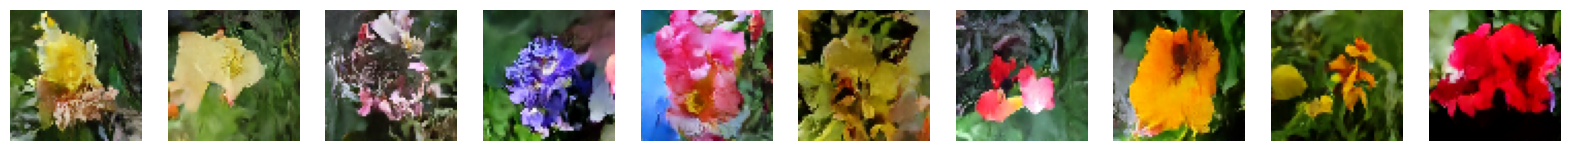

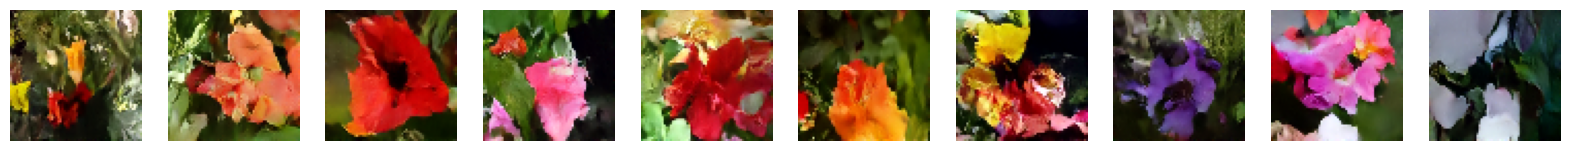

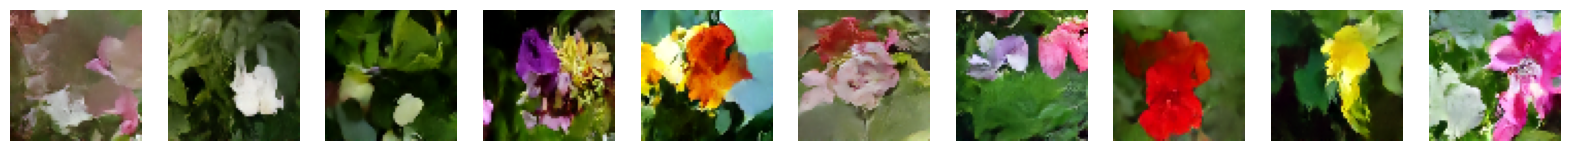

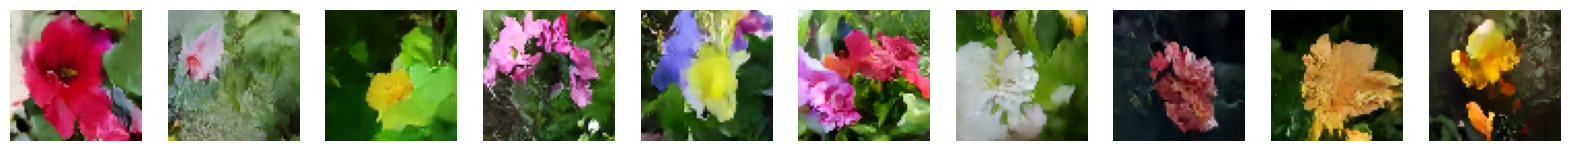

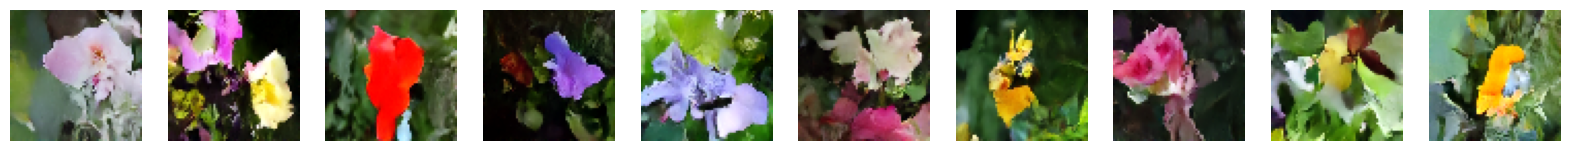

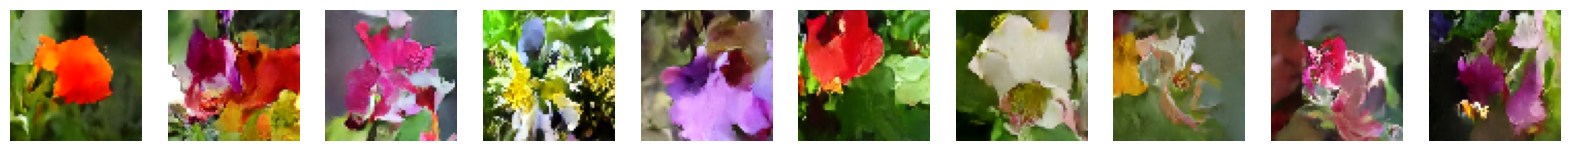

In [48]:
# final results
for _ in range(6):
    diffusion_steps = 50
    #tf.random.set_seed(42)
    generated_images = ddm.generate(
        num_images=10,
        diffusion_steps=diffusion_steps,
    ).numpy()
    display(generated_images,n=10)

In [ ]:
list = [1,3,5,10,30,50]
for diffusion_steps in list:
    tf.random.set_seed(4)
    generated_images = ddm.generate(
        num_images= 7,
        diffusion_steps=diffusion_steps,
    ).numpy()
    display(generated_images,n=7)

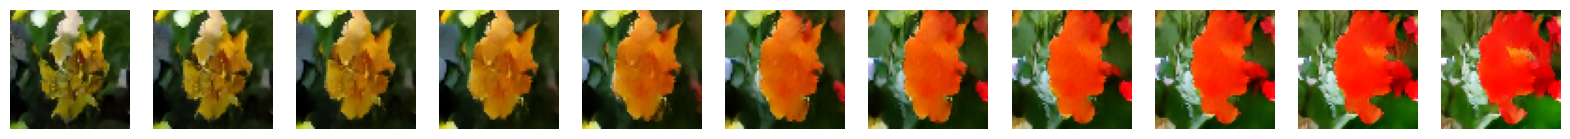

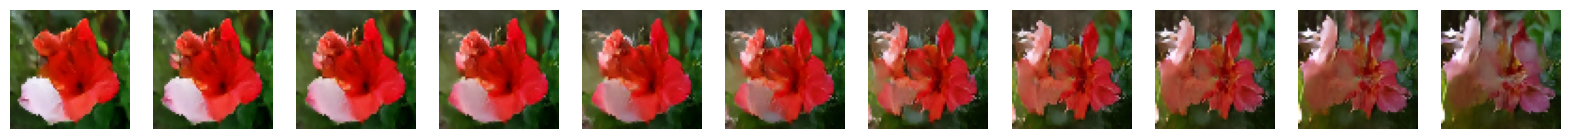

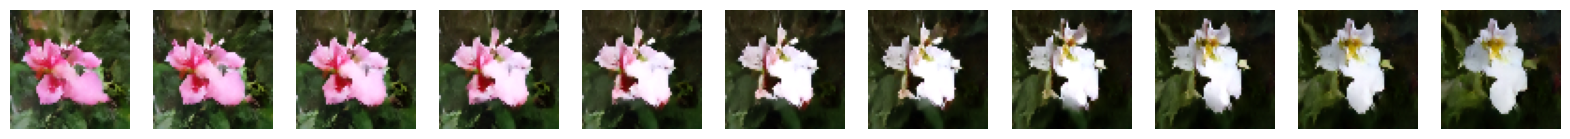

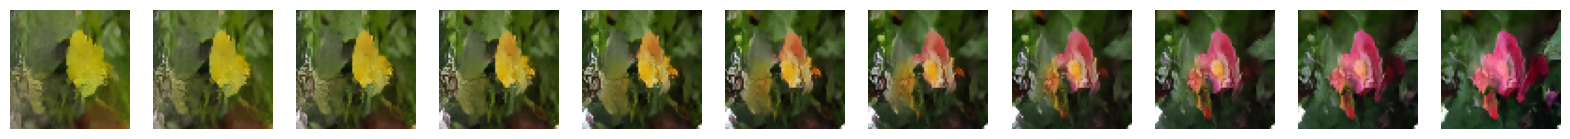

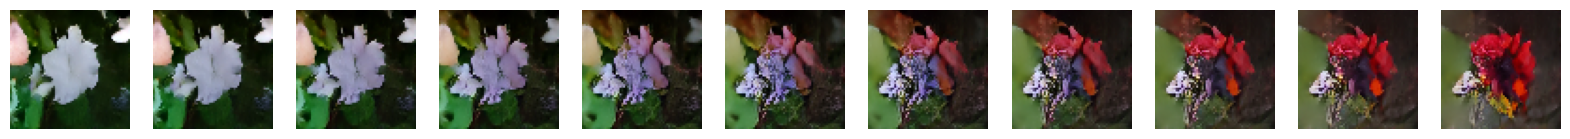

In [49]:
# Interpolation between two points in the latent space
tf.random.set_seed(100)


def spherical_interpolation(a, b, t):
    return np.sin(t * math.pi / 2) * a + np.cos(t * math.pi / 2) * b


for i in range(5):
    a = tf.random.normal(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    b = tf.random.normal(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    initial_noise = np.array(
        [spherical_interpolation(a, b, t) for t in np.arange(0, 1.1, 0.1)]
    )
    generated_images = ddm.generate(
        num_images=2, diffusion_steps=20, initial_noise=initial_noise
    ).numpy()
    display(generated_images, n=11)